Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


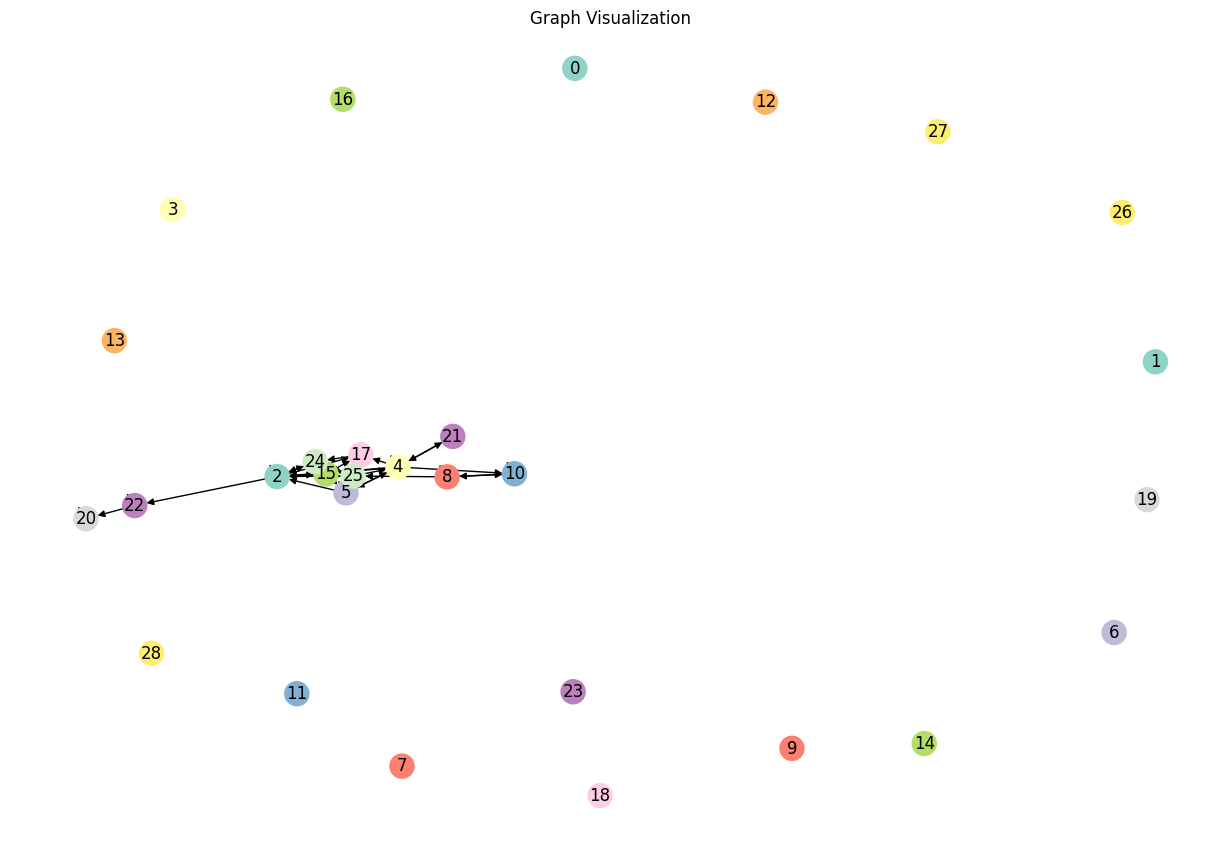

graph_data_list[0]에 해당하는 BlockId: blk_-1608999687919862906


In [3]:
# PyTorch와 관련 라이브러리 설치
!pip install torch torchvision torchaudio
!pip install torch-geometric

# 필요한 라이브러리 임포트
import pandas as pd  # 데이터 처리 라이브러리
import numpy as np  # 수치 계산 라이브러리
import torch  # PyTorch 딥러닝 라이브러리
from torch_geometric.data import Data  # PyTorch Geometric 데이터 클래스
from torch_geometric.nn import GCNConv  # 그래프 컨볼루션 레이어
from torch_geometric.loader import DataLoader  # 그래프 데이터 로더
from sklearn.model_selection import train_test_split  # 데이터 분할 함수
from sklearn.metrics import classification_report  # 성능 평가 함수
import torch.nn.functional as F  # PyTorch 함수들
import ast  # 문자열을 리스트나 딕셔너리로 변환하기 위한 모듈

# Google Drive 마운트 (데이터 파일을 불러오기 위해)
from google.colab import drive
drive.mount('/content/drive')

# 데이터 경로 설정 (데이터 파일들이 저장된 위치)
base_path = '/content/drive/MyDrive/Graph LSTM/HDFS_v1/preprocessed/'
# 각 데이터 파일의 경로 설정
anomaly_label_path = base_path + 'anomaly_label.csv'
event_occurrence_matrix_path = base_path + 'Event_occurrence_matrix.csv'
log_templates_path = base_path + 'HDFS.log_templates.csv'
event_traces_path = base_path + 'Event_traces.csv'

# 데이터 로드
anomaly_label = pd.read_csv(anomaly_label_path)  # 이상치 라벨 데이터
event_occurrence_matrix = pd.read_csv(event_occurrence_matrix_path)  # 이벤트 발생 매트릭스
log_templates = pd.read_csv(log_templates_path)  # 로그 템플릿
event_traces = pd.read_csv(event_traces_path)  # 이벤트 트레이스 데이터

# 라벨 인코딩 (문자열 라벨을 숫자로 변환)
label_dict = {'Normal': 0, 'Anomaly': 1}
anomaly_label['Label'] = anomaly_label['Label'].map(label_dict)

# 이벤트 ID와 템플릿 매핑
event_id_to_template = dict(zip(log_templates['EventId'], log_templates['EventTemplate']))
event_ids = log_templates['EventId'].unique()  # 모든 이벤트 ID 추출
event_id_to_index = {event_id: idx for idx, event_id in enumerate(event_ids)}  # 이벤트 ID를 인덱스로 매핑

# 필요 없는 열 제거 및 결측치 처리
event_occurrence_matrix = event_occurrence_matrix.drop(columns=['Label', 'Type'])  # 불필요한 열 제거
event_occurrence_matrix = event_occurrence_matrix.fillna(0)  # 결측치를 0으로 대체

# 문자열 형태의 리스트를 실제 리스트로 변환하는 함수 정의
import re  # 정규표현식 모듈

def parse_features(s):
    if not s or pd.isna(s):
        return []
    return re.findall(r'E\d+', s)  # 'E'로 시작하는 패턴을 모두 찾아 리스트로 반환

def parse_time_intervals(s):
    if not s or pd.isna(s):
        return []
    s = s.strip('[]')  # 양쪽의 대괄호 제거
    elements = s.split(',')  # 콤마로 분리
    elements = [float(e.strip()) for e in elements if e.strip()]  # 공백 제거 후 실수형 변환
    return elements

# 문자열을 리스트로 변환하여 적용
event_traces['Features'] = event_traces['Features'].apply(parse_features)
event_traces['TimeInterval'] = event_traces['TimeInterval'].apply(parse_time_intervals)

# 'BlockId' 데이터 타입을 문자열로 통일
anomaly_label['BlockId'] = anomaly_label['BlockId'].astype(str)
event_traces['BlockId'] = event_traces['BlockId'].astype(str)

# 데이터 병합 (이벤트 트레이스와 라벨을 BlockId 기준으로 병합)
merged_data = pd.merge(event_traces, anomaly_label.rename(columns={'Label': 'AnomalyLabel'}), on='BlockId', how='inner')

# 그래프 생성 함수 정의
def create_graph(block_events, block_id):
    nodes = []
    edge_index = [[], []]  # 엣지의 출발점과 도착점을 담는 리스트

    # 이벤트 ID를 인덱스로 변환하여 노드 리스트 생성
    for event_id in event_ids:
        node_idx = event_id_to_index[event_id]
        nodes.append(node_idx)

    # 이벤트 시퀀스에 따라 엣지 생성
    for i in range(len(block_events) - 1):
        src = event_id_to_index[block_events[i]]  # 현재 이벤트의 인덱스
        dst = event_id_to_index[block_events[i + 1]]  # 다음 이벤트의 인덱스
        edge_index[0].append(src)  # 엣지의 출발점
        edge_index[1].append(dst)  # 엣지의 도착점

    # 텐서로 변환
    edge_index = torch.tensor(edge_index, dtype=torch.long)
    x = torch.eye(len(event_ids))  # 노드 특징 매트릭스 (단위행렬: 원-핫 인코딩)
    return x, edge_index, block_id  # 노드 특징과 엣지 인덱스, BlockId 반환

# 그래프 데이터 리스트 생성
graph_data_list = []

for idx, row in merged_data.iterrows():
    label = row['AnomalyLabel']  # 라벨 (정상: 0, 이상: 1)
    events = row['Features']  # 이벤트 시퀀스
    block_id = row['BlockId']  # BlockId 추가

    # 이벤트가 1개 이하인 경우 제외
    if len(events) <= 1:
        continue

    # 그래프 생성
    x, edge_index, block_id = create_graph(events, block_id)

    # 그래프 데이터 객체 생성 (PyTorch Geometric의 Data 클래스)
    data = Data(x=x, edge_index=edge_index, y=torch.tensor([label], dtype=torch.long))
    data.block_ids = [block_id]  # block_ids 추가 (문자열로)
    graph_data_list.append(data)  # 그래프 데이터 리스트에 추가


# 그래프 시각화를 위한 라이브러리 임포트
import torch_geometric
import networkx as nx  # 그래프 시각화 라이브러리
import matplotlib.pyplot as plt  # 그래프 시각화 라이브러리
from torch_geometric.utils import to_networkx  # PyTorch Geometric 그래프를 NetworkX 그래프로 변환

# 그래프 데이터 중 하나 선택 (첫 번째 그래프)
data = graph_data_list[0]

# NetworkX 그래프로 변환
G = to_networkx(data, node_attrs=['x'], edge_attrs=None)

# 그래프 레이아웃 설정 (시드 고정으로 동일한 레이아웃 보장)
pos = nx.spring_layout(G, seed=42)

# 노드 색상 지정 (노드 인덱스에 따라 색상 지정)
node_colors = [i for i in range(len(G.nodes()))]

# 그래프 그리기
plt.figure(figsize=(12, 8))
nx.draw(G, pos, with_labels=True, node_color=node_colors, cmap=plt.cm.Set3)
plt.title('Graph Visualization')
plt.show()

# 첫 번째 그래프 데이터가 어떤 BlockId에 해당하는지 확인
first_graph_index = 0  # 첫 번째 그래프의 인덱스
for idx, row in merged_data.iterrows():
    events = row['Features']
    if len(events) > 1:  # 이벤트가 1개 이상인 경우
        if first_graph_index == 0:
            print(f"graph_data_list[0]에 해당하는 BlockId: {row['BlockId']}")
            break
        first_graph_index -= 1


In [4]:
import torch
import torch.nn.functional as F
from torch.nn import Linear
import torch.nn as nn
from torch_geometric.nn import GCNConv, global_mean_pool

class GNN(torch.nn.Module):
    def __init__(self, num_node_features, hidden_channels, dropout=0.6):
        super(GNN, self).__init__()
        self.conv1 = GCNConv(num_node_features, hidden_channels)
        self.dropout1 = nn.Dropout(dropout)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.dropout2 = nn.Dropout(dropout)
        self.lin = Linear(hidden_channels, 2)  # 그래프 분류를 위한 출력 레이어
        self.dropout3 = nn.Dropout(dropout)

    def forward(self, x, edge_index, batch): #이게 진짜임..우리는 이걸 쓰는거야. init는 디폴트 호출 때 사용되는 거다잉.
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.dropout1(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.dropout2(x)
        x = global_mean_pool(x, batch)  # 그래프 임베딩 생성
        x = self.dropout3(x)
        x = self.lin(x)
        return x

    # block_ids를 이용한 메소드 추가 (필요한 경우)
    def get_block_ids(self, data):
        return data.block_ids


In [5]:
from torch_geometric.loader import DataLoader

batch_size = 32

gnn_train_data, gnn_test_data = train_test_split(graph_data_list, test_size=0.2, random_state=42)

# block_ids를 포함하여 DataLoader 생성
gnn_train_loader = DataLoader(gnn_train_data, batch_size=batch_size, shuffle=True)
gnn_test_loader = DataLoader(gnn_test_data, batch_size=batch_size, shuffle=False)

# block_ids를 포함하도록 DataLoader 수정
for data in gnn_train_loader:
    block_ids = data.block_ids  # 배치에서 block_ids 추출

for data in gnn_test_loader:
    block_ids = data.block_ids  # 배치에서 block_ids 추출


In [6]:
# 디바이스 설정 (GPU 사용 가능하면 GPU 사용)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# GNN 모델 초기화
gnn_model = GNN(num_node_features=len(event_ids), hidden_channels=64, dropout=0.6).to(device)
optimizer = torch.optim.Adam(gnn_model.parameters(), lr=0.0001)  # 최적화 알고리즘 설정
criterion = torch.nn.CrossEntropyLoss()  # 손실 함수 설정

# GNN 모델 학습 루프
num_epochs = 10  # 에폭 수 설정
for epoch in range(num_epochs):
    gnn_model.train()  # 모델을 학습 모드로 설정
    total_loss = 0
    for data in gnn_train_loader:
        data = data.to(device)  # 데이터를 GPU로 전송
        optimizer.zero_grad()  # 옵티마이저의 기울기 초기화

        # 모델을 통해 예측값 산출
        out = gnn_model(data.x, data.edge_index, data.batch)

        # 손실 계산
        loss = criterion(out, data.y)

        # 역전파 및 가중치 업데이트
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(gnn_train_loader)  # 평균 손실 계산
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')  # 학습 과정 출력


Epoch [1/10], Loss: 0.1428
Epoch [2/10], Loss: 0.1301
Epoch [3/10], Loss: 0.1234
Epoch [4/10], Loss: 0.1162
Epoch [5/10], Loss: 0.1068
Epoch [6/10], Loss: 0.0923
Epoch [7/10], Loss: 0.0787
Epoch [8/10], Loss: 0.0693
Epoch [9/10], Loss: 0.0639
Epoch [10/10], Loss: 0.0613


In [7]:
gnn_model.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in gnn_test_loader:
        data = data.to(device)
        out = gnn_model(data.x, data.edge_index, data.batch)
        _, pred = torch.max(out, 1)
        correct += (pred == data.y).sum().item()
        total += data.y.size(0)
accuracy = correct / total
print(f'GNN Test Accuracy: {accuracy:.4f}')


GNN Test Accuracy: 0.9888


              precision    recall  f1-score   support

      Normal       0.99      1.00      0.99    111664
     Anomaly       0.96      0.64      0.77      3349

    accuracy                           0.99    115013
   macro avg       0.97      0.82      0.88    115013
weighted avg       0.99      0.99      0.99    115013



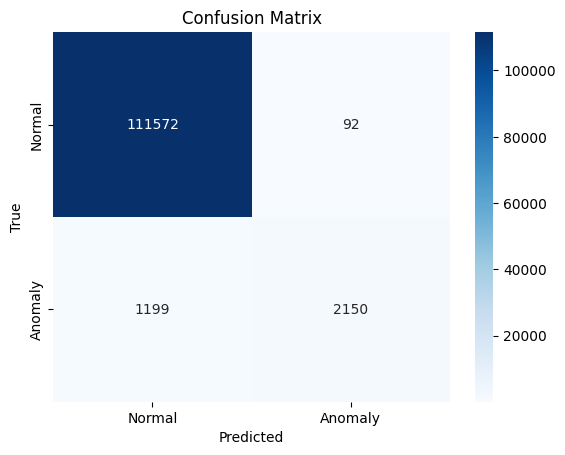

In [8]:
# GNN 모델 평가
gnn_model.eval()  # 모델을 평가 모드로 전환
all_preds = []
all_labels = []
with torch.no_grad():
    for data in gnn_test_loader:
        data = data.to(device)  # 데이터를 GPU로 전송
        outputs = gnn_model(data.x, data.edge_index, data.batch)  # 예측 값 계산
        _, preds = torch.max(outputs, 1)  # 예측 클래스 선택
        all_preds.extend(preds.cpu().numpy())  # 예측 값 저장
        all_labels.extend(data.y.cpu().numpy())  # 실제 라벨 저장

# 성능 평가 보고서 출력
print(classification_report(all_labels, all_preds, target_names=['Normal', 'Anomaly']))

# 혼동 행렬 생성 및 시각화
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 혼동 행렬 생성
cm = confusion_matrix(all_labels, all_preds)  # 혼동 행렬 계산
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Anomaly'], yticklabels=['Normal', 'Anomaly'])  # 시각화
plt.xlabel('Predicted')  # x축 라벨
plt.ylabel('True')  # y축 라벨
plt.title('Confusion Matrix')  # 제목
plt.show()


In [9]:
def respond_to_anomaly(block_id):
    print(f'Block {block_id}: Performing backup...')
    print(f'Block {block_id}: Sending alert to administrator...')
    print(f'Block {block_id}: Adjusting checkpoint settings...')

# 테스트 데이터에 적용
with torch.no_grad():
    for data in gnn_test_loader:
        data = data.to(device)
        outputs = gnn_model(data.x, data.edge_index, data.batch)
        _, preds = torch.max(outputs, 1)
        for i, pred in enumerate(preds):
            if pred.item() == 1:  # Anomaly로 예측된 경우
                block_id = data.block_ids[i]  # block_ids에서 block_id 가져오기
                respond_to_anomaly(block_id)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
Block ['blk_1001410261956352331']: Sending alert to administrator...
Block ['blk_1001410261956352331']: Adjusting checkpoint settings...
Block ['blk_7031175324414481357']: Performing backup...
Block ['blk_7031175324414481357']: Sending alert to administrator...
Block ['blk_7031175324414481357']: Adjusting checkpoint settings...
Block ['blk_4574083752439730626']: Performing backup...
Block ['blk_4574083752439730626']: Sending alert to administrator...
Block ['blk_4574083752439730626']: Adjusting checkpoint settings...
Block ['blk_8233409964705740253']: Performing backup...
Block ['blk_8233409964705740253']: Sending alert to administrator...
Block ['blk_8233409964705740253']: Adjusting checkpoint settings...
Block ['blk_-2531999061313177174']: Performing backup...
Block ['blk_-2531999061313177174']: Sending alert to administrator...
Block ['blk_-2531999061313177174']: Adjusting checkpoint settings...
Block ['blk_-9081556704582697522']: Performing backu